# VCF: formato, tipi di variante e hard filtering

Obiettivi:
- Capire la struttura di base di un file VCF.
- Distinguere SNV vs indel.
- Fare semplici filtri di qualità (QUAL, DP).

Useremo un piccolo VCF **sintetico** definito direttamente nel notebook.

In [1]:
from __future__ import annotations
import io
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Piccolo VCF sintetico

- Header semplificato
- 6 varianti con campi REF/ALT/QUAL/DP immaginari

In [2]:
vcf_text = """##fileformat=VCFv4.2
##INFO=<ID=DP,Number=1,Type=Integer,Description=\"Total Depth\">
##FILTER=<ID=LowQual,Description=\"Low quality\">
#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO
chr1\t1000\trs111\tA\tG\t50\tPASS\tDP=35
chr1\t2000\t.\tC\tT\t12\tLowQual\tDP=8
chr1\t3000\trs222\tG\tA\t80\tPASS\tDP=60
chr1\t4000\t.\tT\tC,G\t5\tLowQual\tDP=5
chr2\t1500\t.\tAC\tA\t40\tPASS\tDP=20
chr2\t2500\t.\tG\tGCT\t25\tPASS\tDP=15
"""

## Parsing del VCF con pandas

Usiamo `io.StringIO` per trattare la stringa come un file.

In [3]:
def read_vcf_to_dataframe(text: str) -> pd.DataFrame:
    lines = text.strip().splitlines()
    header_line = None
    data_lines = []
    for line in lines:
        if line.startswith("##"):
            continue
        if line.startswith("#CHROM"):
            header_line = line
        else:
            data_lines.append(line)
    if header_line is None:
        raise ValueError("Header #CHROM non trovato")

    header = header_line.lstrip("#").split("\t")
    df = pd.read_csv(
        io.StringIO("\n".join(data_lines)),
        sep="\t",
        header=None,
        names=header,
    )
    return df

df = read_vcf_to_dataframe(vcf_text)
df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
0,chr1,1000,rs111,A,G,50,PASS,DP=35
1,chr1,2000,.,C,T,12,LowQual,DP=8
2,chr1,3000,rs222,G,A,80,PASS,DP=60
3,chr1,4000,.,T,"C,G",5,LowQual,DP=5
4,chr2,1500,.,AC,A,40,PASS,DP=20
5,chr2,2500,.,G,GCT,25,PASS,DP=15


Aggiungiamo:
- tipo di variante (snp / indel)
- estrazione del campo DP dall'INFO

In [4]:
def infer_variant_type(ref: str, alt: str) -> str:
    """Molto semplificato:
    - se tutti gli alleli ALT sono lunghezza 1 e REF è lunghezza 1 -> snp
    - altrimenti -> indel (o altro)
    """
    alt_alleles = alt.split(",")
    if len(ref) == 1 and all(len(a) == 1 for a in alt_alleles):
        return "snp"
    else:
        return "indel"

def extract_dp(info: str) -> int | None:
    for part in info.split(";"):
        if part.startswith("DP="):
            try:
                return int(part.split("=", 1)[1])
            except ValueError:
                return None
    return None

df["type"] = df.apply(lambda r: infer_variant_type(r["REF"], r["ALT"]), axis=1)
df["DP"] = df["INFO"].apply(extract_dp)

df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,type,DP
0,chr1,1000,rs111,A,G,50,PASS,DP=35,snp,35
1,chr1,2000,.,C,T,12,LowQual,DP=8,snp,8
2,chr1,3000,rs222,G,A,80,PASS,DP=60,snp,60
3,chr1,4000,.,T,"C,G",5,LowQual,DP=5,snp,5
4,chr2,1500,.,AC,A,40,PASS,DP=20,indel,20
5,chr2,2500,.,G,GCT,25,PASS,DP=15,indel,15


## Statistiche base: quanti SNP e quanti indel?

In [5]:
df["type"].value_counts()

type
snp      4
indel    2
Name: count, dtype: int64

## Distribuzione di QUAL e DP

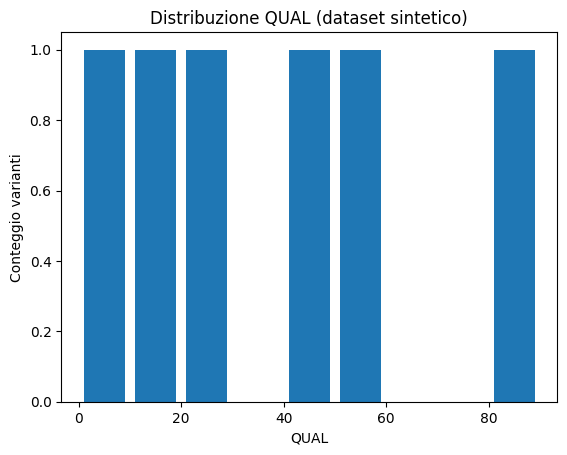

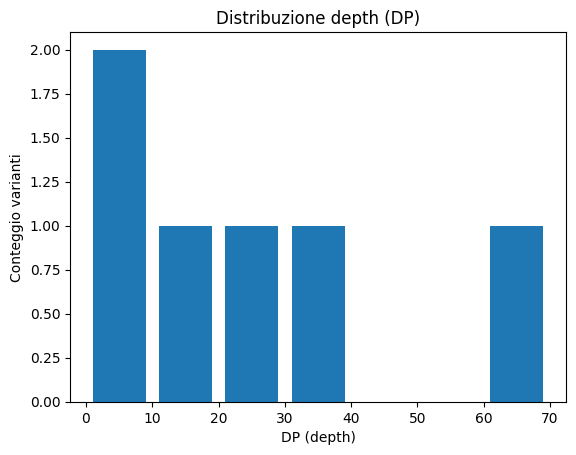

In [6]:
plt.hist(df["QUAL"], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90], rwidth=0.8)
plt.xlabel("QUAL")
plt.ylabel("Conteggio varianti")
plt.title("Distribuzione QUAL (dataset sintetico)")
plt.show()

plt.hist(df["DP"], bins=[0, 10, 20, 30, 40, 50, 60, 70], rwidth=0.8)
plt.xlabel("DP (depth)")
plt.ylabel("Conteggio varianti")
plt.title("Distribuzione depth (DP)")
plt.show()

## Hard filtering semplice

Esempio (puramente didattico):
- QUAL >= 30
- 10 <= DP <= 50
- FILTER == "PASS"

In [7]:
min_qual = 30
min_dp = 10
max_dp = 50

mask = (
    (df["QUAL"] >= min_qual)
    & (df["DP"] >= min_dp)
    & (df["DP"] <= max_dp)
    & (df["FILTER"] == "PASS")
)

filtered = df[mask].copy()

print("Varianti totali   :", len(df))
print("Varianti filtrate :", len(filtered))
filtered[["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "DP", "type"]]

Varianti totali   : 6
Varianti filtrate : 2


,CHROM,POS,ID,REF,ALT,QUAL,DP,type
0,chr1,1000,rs111,A,G,50,35,snp
4,chr2,1500,.,AC,A,40,20,indel


In un VCF reale, filtri come questi:
- si applicano dopo una pipeline accurata di variant calling
- sono molto più sofisticati (es. VQSR, filtri su MQ, QD, FS, SOR, ...).

Questo esempio serve solo a visualizzare il concetto e i suoi effetti sul numero di varianti.